<a href="https://colab.research.google.com/github/ThuanPhong0126/Machine-Translation-Chinese-English/blob/main/NMT_Chinese_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Machine_Translation

/content/drive/MyDrive/Machine_Translation


Encoder-Decoder Architecture

![Encoder-Decoder Architecture](https://nthu-datalab.github.io/ml/labs/13-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/encoder_to_decoder.png)

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import re
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

from pylab import *
from matplotlib.font_manager import FontProperties

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs, ", len(logical_gpus), "logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs,  1 logical GPUs


In [5]:
path_dataset = "./cmn.txt"

### Data Preprocessing

In [6]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn')

def preprocess_eng(w):
  w = unicode_to_ascii(w.lower().strip())
  #Python padding punctuation with white spaces keeping punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  #Replace several spaces with one spaces
  w = re.sub(r'[" "]+'," ",w)
  #replacing everythong with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
  w = w.rstrip().strip()
  w = '<start> '+w+' <end>'
  return w

def preprocess_chinese(w):
  w= unicode_to_ascii(w.lower().strip())
  w = re.sub(r'[" "]+', "", w)
  w = w.rstrip().strip()
  w = " ".join(list(w))
  w = '<start> '+w+' <end>'
  return w

In [7]:
en_sentence = u"May I borrow this book?"
chn_sentence = u"我可以借這本書麼？"
print(preprocess_eng(en_sentence))
print(preprocess_chinese(chn_sentence))
print(preprocess_chinese(chn_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
<start> 我 可 以 借 這 本 書 麼 ？ <end>
b'<start> \xe6\x88\x91 \xe5\x8f\xaf \xe4\xbb\xa5 \xe5\x80\x9f \xe9\x80\x99 \xe6\x9c\xac \xe6\x9b\xb8 \xe9\xba\xbc \xef\xbc\x9f <end>'


In [8]:
def create_dataset(path_dataset, num_examples=None):
  lines = open(path_dataset, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[w for w in l.split('\t')[:2]] for l in lines]
  word_pairs = [[preprocess_eng(w[0]), preprocess_chinese(w[1])] for w in word_pairs]
  return word_pairs

word_pairs = create_dataset(path_dataset)
word_pairs[50:60]

[['<start> he runs . <end>', '<start> 他 跑 。 <end>'],
 ['<start> help me . <end>', '<start> 帮 我 一 下 。 <end>'],
 ['<start> help us . <end>', '<start> 帮 帮 我 们 吧 ！ <end>'],
 ['<start> hit tom . <end>', '<start> 去 打 汤 姆 。 <end>'],
 ['<start> hold on . <end>', '<start> 坚 持 。 <end>'],
 ['<start> hug tom . <end>', '<start> 抱 抱 汤 姆 ！ <end>'],
 ['<start> hug tom . <end>', '<start> 请 抱 紧 汤 姆 。 <end>'],
 ['<start> i agree . <end>', '<start> 我 同 意 。 <end>'],
 ['<start> i m ill . <end>', '<start> 我 生 病 了 。 <end>'],
 ['<start> i m sad . <end>', '<start> 我 很 难 过 。 <end>']]

In [9]:
en, ch = zip(*create_dataset(path_dataset))
print(en[-1])
print(ch[-1])
assert len(en)==len(ch)
print("Size: ", len(en))

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如 果 一 個 人 在 成 人 前 沒 有 機 會 習 得 目 標 語 言 ， 他 對 該 語 言 的 認 識 達 到 母 語 者 程 度 的 機 會 是 相 當 小 的 。 <end>
Size:  26388


In [10]:
def max_length(tensor):
  return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  #generate a dictionary
  lang_tokenizer.fit_on_texts(lang)
  #output the vector sequences
  tensor = lang_tokenizer.texts_to_sequences(lang)
  #padding sentences to the same length
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  # regard Chinese as source sentence, regard English as target sentence
  target_lang, input_lang = zip(*create_dataset(path_dataset, num_examples))
  input_tensor, input_lang_tokenizer = tokenize(input_lang)
  target_tensor, target_lang_tokenizer = tokenize(target_lang)
  return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

In [11]:
num_examples = 15000
input_tensor, target_tensor, input_lang, target_lang = load_dataset(path_dataset, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

#Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size = 0.1
)

print(f"Training data: {len(input_tensor_train)}\nTest data: {len(input_tensor_val)}")

Training data: 23749
Test data: 2639


In [12]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f"{t} ----> {lang.index_word[t]}")

print("Input Language; index to word mapping")
convert(input_lang, input_tensor_train[0])
print()
print("Target language; index to word mapping")
convert(target_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7 ----> 你
26 ----> 們
13 ----> 在
513 ----> 哭
40 ----> 嗎
11 ----> ？
2 ----> <end>

Target language; index to word mapping
1 ----> <start>
31 ----> are
7 ----> you
759 ----> guys
692 ----> crying
9 ----> ?
2 ----> <end>


### Create a tf.data dataset

In [13]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epochs = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_input_size = len(input_lang.word_index)+1
vocab_target_size = len(target_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape 

(TensorShape([128, 46]), TensorShape([128, 38]))

### Encoder

In [14]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True, 
                                   return_state = True,
                                   recurrent_activation='sigmoid',
                                   recurrent_initializer='glorot_uniform')
  def call(self,x , hidden):
    #after embedding, x.shape==(batch_size, max_length, embedding_dim)->(128,46,256)
    x = self.embedding(x)
    #output shape==(batch_size, max length, units)->(128, 46, 1024)
    #state is the hidde state of the last timestamp, shape=(batch_size, units)->(128,1024)
    output, state = self.gru(x, initial_state=hidden)

    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))

In [15]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

#Sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: ', sample_output.shape)
print('Encoder hidden state shape: ', sample_hidden.shape)

# the output and the hidden state of GRU is equal
print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder output shape:  (128, 46, 1024)
Encoder hidden state shape:  (128, 1024)
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


### Attention

In [16]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    #query shape == (batch size, hidden size)
    #hidden with time axis shape == (batch size,1, hidden size)
    #i am doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    #score shape == (batch size, max length, 1)
    #we get 1 at the last axis bacause we are applying score to self.V
    #the shape of the tensor before applying self.V is (batch size, max length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    #attention weights shape == (batch size, max length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    #context vector shape == (batch size, max length, hidden size)
    context_vector = attention_weights * values

    #context vector shape after sum == (batch size, hidden size)
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [17]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 46, 1)


### Decoder

In [18]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # the dimension of the output is the vocab size, through the softmax function,
    # this layer will return the probability of each word in the dictory
    self.fc = tf.keras.layers.Dense(vocab_size)

    #used for anttention
    self.attention = BahdanauAttention(vocab_size)

  def call(self, x, hidden, enc_output):
    #This function outputs a result at each timestamp
    #The hidden state of first timestamp in the decoder is the hidden state of last timestamp in the encoder
    context_vector, attention_weights = self.attention(hidden, enc_output)

    #x shape after passing through embedding == (batch size, 1, embedding dim)
    x = self.embedding(x)

    #concatenate the input x and the context vector, as the input of the GRU
    #context vector shape==(batch size, units)->(128, 1024)
    #x shape after concatenation==(batch size, 1, embedding dim+hidden size)->(128,1,1024+256)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # get the output and state of the current timestamp
    # output shape == (batch_size, 1, units) -> (128, 1, 1024) 
    # state shape == (batch_size, units) -> (128, 1024)
    output, state = self.gru(x)

    #output shape == (batch size, hidden size)->(128, 1024)
    output = tf.reshape(output, (-1, output.shape[2]))

    #output shape==(batch size, vocab)->(128, 6082)
    x = self.fc(output)

    return x, state, attention_weights

In [19]:
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 6755)


### Define the optimizer and the loss function

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [21]:
checkpoint_dir = "./checkpoints/chinese-eng"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    #feed the <start> as the input of the decoder
    #dec input shape == (batch size, 1)->(128, 1)
    dec_input  =tf.expand_dims([target_lang.word_index['<start>']]*BATCH_SIZE,1)

    # Teacher forcing - feeding the target as the next input
    # because of the data preprocessing(add a start token to the sentence)
    # the first word is <start>, so t starts from 1(not 0)
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # targ[:, t] is the true label(index of the word) of every sentence(in a batch) 
      # at the current timestamp
      # like [  85   18   25   25  ···  1047   79   13], shape == (batch_size,) -> (128,)
      # predictions shape == (batch_size, vocab_size) -> (128, 6082)
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    #collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    #calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)

    #apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [23]:
EPOCHS = 25

for epoch in range(EPOCHS):
  start = time.time()

  #get the initial hidden state of gru
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epochs)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch_loss%100==0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy()}')

  #saving checkpoint the model every 5 epocs
  if (epoch+1)%5==0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epochs}')
  print(f'time taken for 1 epoch {time.time()-start}')

Epoch 1 Loss 1.1043102741241455
time taken for 1 epoch 333.83062839508057
Epoch 2 Loss 0.8416135907173157
time taken for 1 epoch 296.1163806915283
Epoch 3 Loss 0.7129939794540405
time taken for 1 epoch 296.3932695388794
Epoch 4 Loss 0.6042443513870239
time taken for 1 epoch 296.49609756469727
Epoch 5 Loss 0.5030615925788879
time taken for 1 epoch 298.59099864959717
Epoch 6 Loss 0.41558945178985596
time taken for 1 epoch 296.56155133247375
Epoch 7 Loss 0.339623361825943
time taken for 1 epoch 296.52263140678406
Epoch 8 Loss 0.27388593554496765
time taken for 1 epoch 296.4712345600128
Epoch 9 Loss 0.21988479793071747
time taken for 1 epoch 296.4626166820526
Epoch 10 Loss 0.17386150360107422
time taken for 1 epoch 298.2659709453583
Epoch 11 Loss 0.13810282945632935
time taken for 1 epoch 296.4075005054474
Epoch 12 Loss 0.11114412546157837
time taken for 1 epoch 296.42931604385376
Epoch 13 Loss 0.0871957391500473
time taken for 1 epoch 296.38758158683777
Epoch 14 Loss 0.06751136481761932
t

In [30]:
def evaluate(sentence):
  #max length target 38, max length input 64
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_chinese(sentence)

  #convert each word to the index in the test sentence
  inputs = [input_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  #hidden shape==(1, 1024)
  hidden = [tf.zeros((1, units))]

  # enc out shape == (1, max_length_inp, 1024) -> (1, 46, 1024)
  # enc hidden shape == (1, 1024)
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    #storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    #get the index which has the highest probability
    predicted_id = tf.argmax(predictions[0]).numpy()
    #convert the index to the word
    result += target_lang.index_word[predicted_id]+' '

    #when the decoder predict the end, stop prediction
    if target_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    #the predict id is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
  # you need to change the fname based on your system, and the Chinese can be displayed in the plot
  font = FontProperties(fname=r"./TaipeiSansTCBeta-Regular.ttf", size=14)
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  # set the x-tick/y-tick labels with list of string labels
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=font)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=font)

  # set tick locators
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [31]:
checkpoint_dir = './checkpoints/chinese-eng'
print(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

./checkpoints/chinese-eng/ckpt-5


Input: <start> 你 今 晚 會 去 派 對 嗎 ? <end>
Predicted translation: will you go to the party tonight ? <end> 


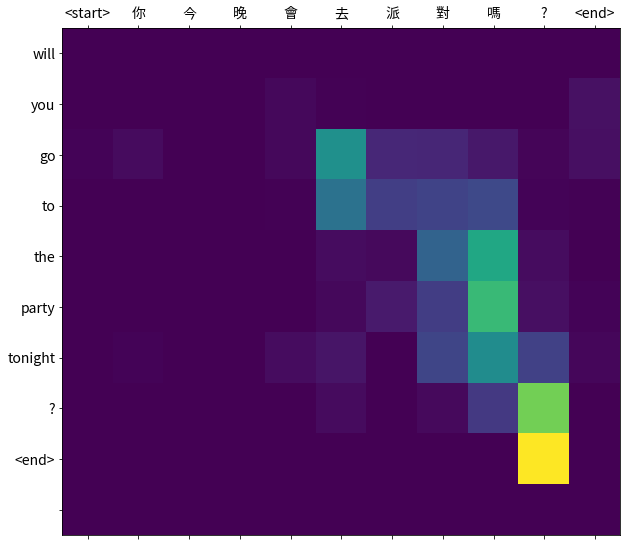

In [32]:
translate('你今晚會去派對嗎?')

Input: <start> 她 明 年 會 去 美 國 嗎 ? <end>
Predicted translation: will she go to america next year ? <end> 


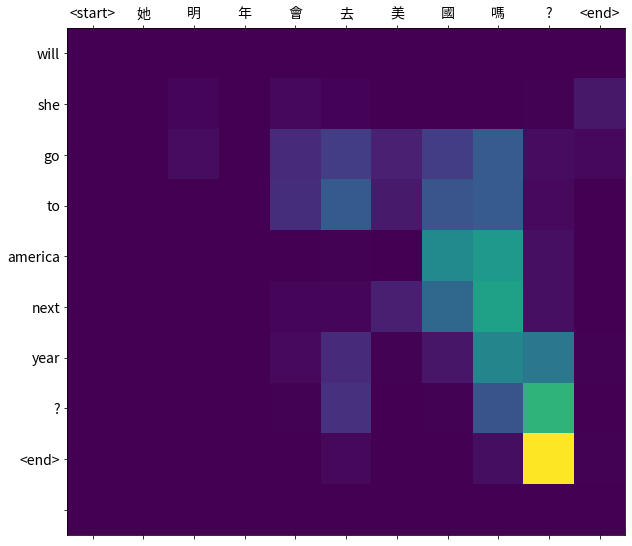

In [33]:
translate('她明年會去美國嗎?')